# Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## K-Means

In [2]:
from sklearn.datasets import make_blobs

In [3]:
blob_centers=np.array(
    [[0.2,2.3],
     [-1.5,2.3],
     [-2.8,1.8],
     [-2.8,2.8],
     [-2.8,1.3]])
blob_std= np.array([0.4,0.3,0.1,0.1,0.1])

In [4]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                 cluster_std=blob_std, random_state=7)

In [5]:
def plot_clusters(X,y=None):
    plt.scatter(X[:,0],X[:,1],c=y,s=1)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14, rotation=0)
    

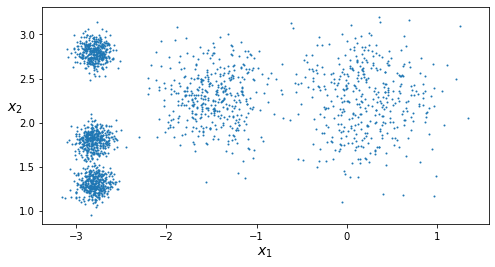

In [6]:
plt.figure(figsize=(8,4))
plot_clusters(X)

In [7]:
from sklearn.cluster import KMeans
k=5
kmeans=KMeans(n_clusters=k)
y_pred=kmeans.fit_predict(X)

In [8]:
y_pred

array([4, 2, 1, ..., 3, 1, 2])

In [9]:
y_pred is kmeans.labels_

True

In [10]:
kmeans.cluster_centers_

array([[-1.46679593,  2.28585348],
       [ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

In [11]:
kmeans.labels_

array([4, 2, 1, ..., 3, 1, 2])

In [12]:
X_new=np.array([[0,2],[3,2],[-3,3],[-3,2.5]])
kmeans.predict(X_new)

array([1, 1, 3, 3])

In [13]:
def plot_data(X):
    plt.plot(X[:,0],X[:,1],'k.', markersize=2)
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights>weights.max()/10]
    plt.scatter(centroids[:,0], centroids[:,1],
               marker='o', s=35, linewidths=8,
               color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:,0], centroids[:,1],
               marker='x', s=2, linewidths=12,
               color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels=True, show_ylabels=True):
    mins=X.min(axis=0) -0.1
    maxs=X.max(axis=0) +0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                        np.linspace(mins[1], maxs[1], resolution))
    Z=clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z=Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),cmap='Pastel2')
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel('$x_2$', fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

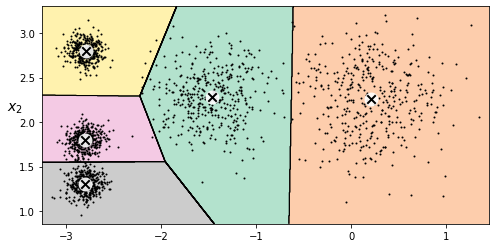

In [14]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)

ハードクラスタリング:インスタンスごとに最も近いクラスターを任意に選択

`transform`で各インスタンスから5つの重心までの距離を測定

In [17]:
kmeans.transform(X_new)

array([[1.49439034, 0.32995317, 2.81093633, 2.9042344 , 2.88633901],
       [4.4759332 , 2.80290755, 5.80730058, 5.84739223, 5.84236351],
       [1.69136631, 3.29399768, 1.21475352, 0.29040966, 1.71086031],
       [1.54808703, 3.21806371, 0.72581411, 0.36159148, 1.21567622]])

これは各インスタンスとセントロイド間のユークリッド距離に等しい。

In [16]:
np.linalg.norm(np.tile(X_new, (1,k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[1.49439034, 0.32995317, 2.81093633, 2.9042344 , 2.88633901],
       [4.4759332 , 2.80290755, 5.80730058, 5.84739223, 5.84236351],
       [1.69136631, 3.29399768, 1.21475352, 0.29040966, 1.71086031],
       [1.54808703, 3.21806371, 0.72581411, 0.36159148, 1.21567622]])

In [18]:
kmeans.inertia_

211.59853725816836

inertiaは各インスタンスとセントロイドの平均二乗距離。

In [19]:
X_dist=kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

`score`は負のinertia(greater is better)

In [20]:
kmeans.score(X)

-211.59853725816834

sklearnのKMeansの初期化はKMeans++がデフォルト(`init="k-means++"`)、オリジナルのKMeansを動かすには`init="random"`とする。

In [21]:
good_init=np.array([[-3,3], [-3,2],[-3,1],[-1,2],[0,2]])
kmeans=KMeans(n_clusters=5, init = good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

高速化手法として、不要な距離の計算をしないようにできる。三角不等式の使用と距離の上下限を記録することで達成する。  
`algorithm="elkan"`と指定する。  
elkanはスパースなデータに対応しないため、データがdenseなら"elkan"、スパースなら"full"を自動選択する。

In [22]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

153 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [23]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

946 ms ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


テキストでは差が出なかったが結構差が出た。

In [24]:
from sklearn.cluster import MiniBatchKMeans

In [25]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [26]:
minibatch_kmeans.inertia_

211.65239850433193

In [27]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target=mnist.target.astype(np.int64)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist['data'], mnist['target'], random_state=42)

In [30]:
filename = 'my_mnist.data'
X_mm=np.memmap(filename, dtype='float32', mode= 'write', shape=X_train.shape)
X_mm[:]=X_train

In [31]:
minibatch_kmeans= MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

C:\Users\tkuramot\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

In [32]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace= False)]

In [33]:
np.random.seed(42)

In [34]:
k=5
n_init=10
n_iterations=100
batch_size=100
init_size=500
evaluate_on_last_n_iters = 10

best_kmeans= None

for init in range(n_init):
    minibatch_kmeans=MiniBatchKMeans(n_clusters=k, init_size= init_size)
    X_init=load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    
    minibatch_kmeans.sum_inertia_=0
    for iteration in range(n_iterations):
        X_batch=load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >=n_iterations -evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
        
    if (best_kmeans is None or minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

C:\Users\tkuramot\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Users\tkuramot\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Users\tkuramot\anaconda3\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable 

In [35]:
best_kmeans.score(X)

-211.6257187889114

In [36]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

93.2 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

429 ms ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
from timeit import timeit

In [40]:
times= np.empty((100,2))
inertias=np.empty((100,2))
for k in range(1, 101):
    kmeans_=KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans= MiniBatchKMeans(n_clusters=k, random_state=42)
    print('\r{}/{}'.format(k, 100),end="")
    times[k-1, 0]=timeit("kmeans_.fit(X)", number=10, globals= globals())
    times[k-1, 1]=timeit("minibatch_kmeans.fit(X)", number=10, globals= globals())
    inertias[k-1, 0]=kmeans_.inertia_
    inertias[k-1, 1]=minibatch_kmeans.inertia_
    

100/100

(1.0, 100.0, 0.0, 12.0)

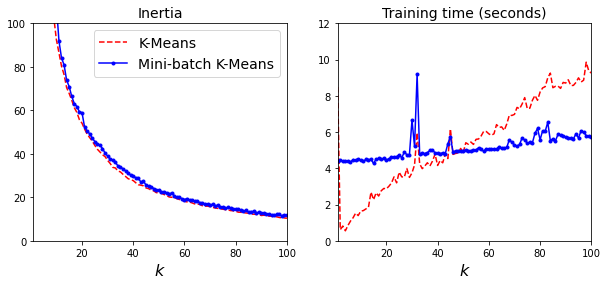

In [43]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1,101), inertias[:,0], "r--", label = 'K-Means')
plt.plot(range(1,101), inertias[:,1], "b.-", label = 'Mini-batch K-Means')
plt.xlabel('$k$', fontsize=16)
plt.title('Inertia', fontsize=14)
plt.legend(fontsize=14)
plt.axis([1,100,0,100])

plt.subplot(122)
plt.plot(range(1,101), times[:,0], "r--", label = 'K-Means')
plt.plot(range(1,101), times[:,1], "b.-", label = 'Mini-batch K-Means')
plt.xlabel('$k$', fontsize=16)
plt.title('Training time (seconds)', fontsize=14)
plt.axis([1,100,0,12])
